In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-09 13:01:38.109341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 13:01:38.252640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-09 13:01:38.252659: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-09 13:01:38.910685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

# Fitting differential operator

In [36]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            if train_var:
                var = np.random.choice([10,20,50])
            else:
                #var = abs(var_u - np.random.exponential(var_d))
                var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            y = np.expand_dims(y,axis=-1)
            x = np.copy(y)
            y = tf.image.image_gradients(tf.constant(np.array([y])))
            y = (y[0]**2 + y[1]**2)[0]
            
            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [63]:
BATCH_SIZE = 10
var_d=0
var_u=0

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

In [64]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

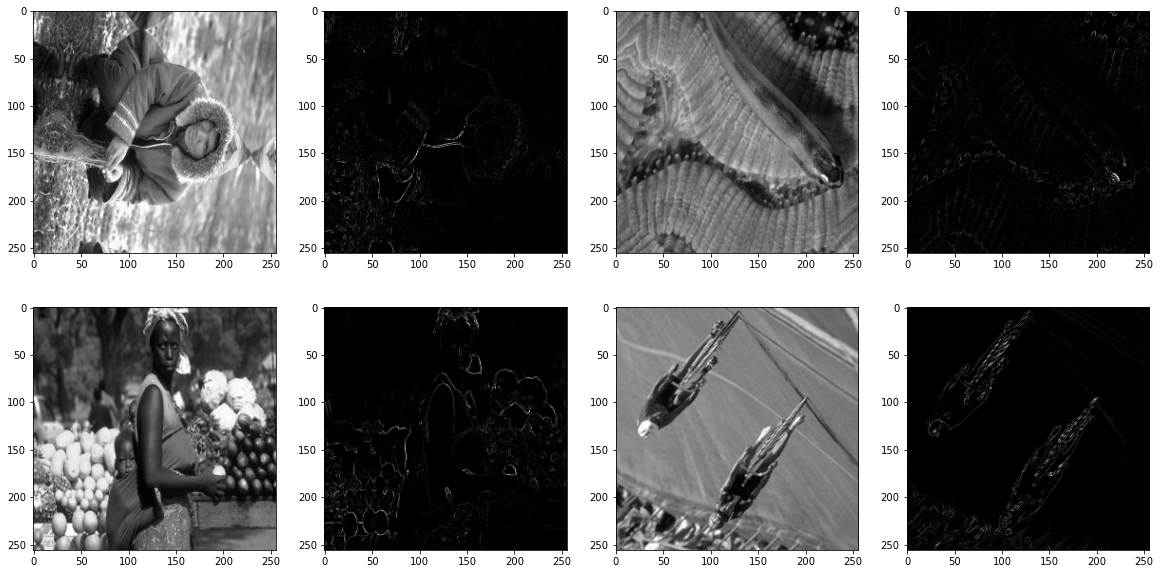

In [65]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

In [357]:
def regularizer(x):
    return 1e-5 * tf.reduce_sum(tf.pow(tf.abs(x),1/2)) + 1e-4*tf.reduce_sum(tf.abs(x))



input_shape = image_size + (1,)
inputs = tf.keras.Input(shape=input_shape,name='input')

dx,dy = tf.keras.layers.Lambda(lambda z:tf.image.image_gradients(z))(inputs)
d = tf.keras.layers.Concatenate()((dx,dy))
dxx,dxy = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(dx)
dx2 = tf.keras.layers.Concatenate()((dxx,dxy))
dyx,dyy = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(dy)
dy2 = tf.keras.layers.Concatenate()((dyx,dyy))
grad = tf.keras.layers.Concatenate()((dx,dy,dxx,dxy,dyx,dyy))
grad = tf.keras.layers.Lambda(lambda z:tf.pow(z,2))(grad)

x = tf.keras.layers.Conv2D(16,3)(inputs)
x = tf.keras.layers.MaxPool2D(3)(x)
x = tf.keras.layers.Conv2D(32,3)(x)
x = tf.keras.layers.MaxPool2D(3)(x)
flatten = tf.keras.layers.Flatten()(x)
coeffs = tf.keras.layers.Dense(32)(flatten)
coeffs = tf.keras.layers.Dense(6,activity_regularizer=regularizer)(coeffs)
x = tf.keras.layers.multiply((coeffs,grad))
x = tf.keras.layers.Lambda(lambda z:tf.unstack(z,axis=-1))(x)
x = tf.keras.layers.add((x))
x = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-1))(x)


model = tf.keras.models.Model(inputs, x)
model.layers[-1].trainble = False
model.summary()

Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_117 (Conv2D)            (None, 254, 254, 16  160         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_66 (MaxPooling2D  (None, 84, 84, 16)  0           ['conv2d_117[0][0]']             
 )                                                                                         

In [358]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss="mse")
history = model.fit(
            gen_batch_train,
            epochs=20,
            steps_per_epoch=100,
            validation_data=gen_batch_val,
            validation_steps=10,
            shuffle=False,
            callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)],
            use_multiprocessing=True,
            workers=1
        )

Epoch 1/20
100/100 [==============================] - 25s 243ms/step - loss: 0.0013 - val_loss: 2.5570e-04 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 24s 240ms/step - loss: 2.3429e-04 - val_loss: 2.2803e-04 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 24s 241ms/step - loss: 2.1908e-04 - val_loss: 2.1886e-04 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 24s 238ms/step - loss: 2.2888e-04 - val_loss: 2.2521e-04 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 22s 225ms/step - loss: 2.1751e-04 - val_loss: 2.0748e-04 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 2.1250e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 [==============================] - 23s 233ms/step - loss: 2.1250e-04 - val_loss: 2.1018e-04 - lr: 0.0010
Epoch 7/20
100/100 [==============================] - 24s 245ms/step - loss: 2.0511e-04 - val_loss: 2.1228e-04 - 

KeyboardInterrupt: 

In [359]:
xs, ys = next(gen_batch_val.as_numpy_iterator())
p = model(ys)

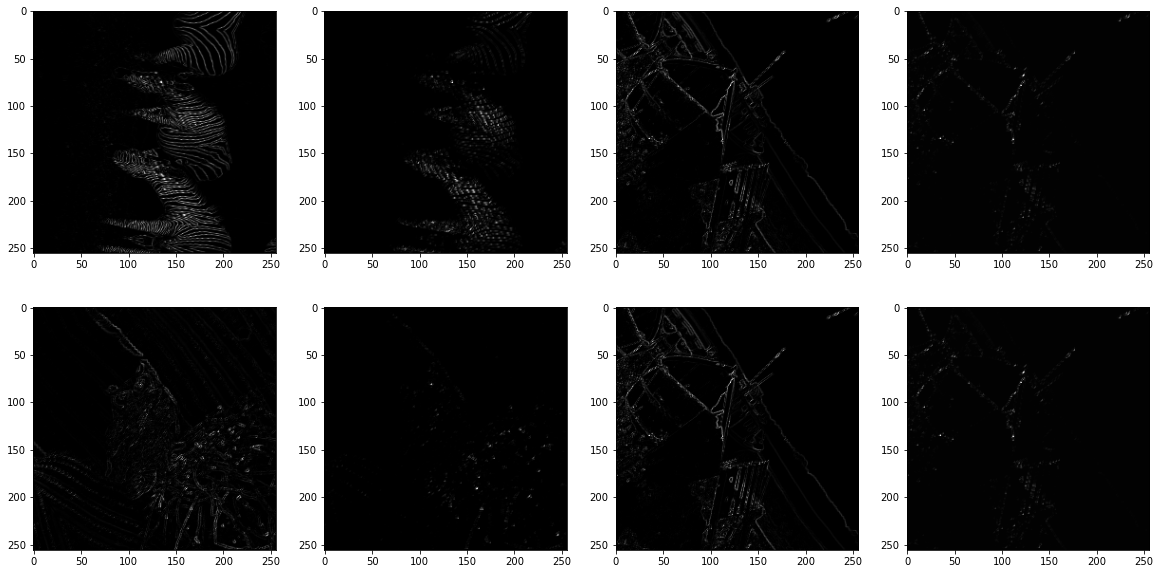

In [360]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(p[_]),cmap='gray')
        
plt.show()

In [361]:
model1 = tf.keras.Model(model.input,model.layers[-6].output)

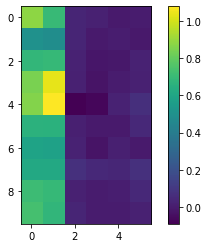

In [362]:
plt.imshow(model1(xs).numpy())
plt.colorbar()
plt.show()

# Perona-Malik model

In [2]:
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return x

In [3]:
class function_type:
    def splines(y,num_classes,order):


        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)

        a = tf.keras.layers.Reshape((num_classes,order))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def decreasing(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)
        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        a = tf.keras.layers.Lambda(lambda z:-tf.math.pow(z,2))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def flux(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        s0 = tf.keras.layers.Dense(1,activation='sigmoid')(y)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s0))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)


        minimum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s0,minimum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s0,a))
        fun = tf.keras.layers.add((coeffs,fun))
        minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(z[...,0],axis=-1))(fun)
        minimum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.less_equal(-z,0),dtype=tf.float32))(minimum)
        minimum = tf.keras.layers.multiply((minimum,minimum_neg))

        b = tf.keras.layers.add((b,minimum))

        a_pos,b_pos = a,b

        b_middle = tf.keras.layers.Dense(1,activation='linear')(y)
        b_middle = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_middle)


        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        s1 = tf.keras.layers.Lambda(lambda z: tf.ones_like(z)-z)(s0)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s1))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_middle))
        b = tf.expand_dims(b,axis=-1)


        maximum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s1,maximum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s1))
        coeffs = tf.keras.layers.add((coeffs,s0))
        coeffs = tf.keras.layers.multiply((a,coeffs))
        fun = tf.keras.layers.add((coeffs,fun))
        maximum = tf.keras.layers.Lambda(lambda z:-tf.reduce_max(z[...,0],axis=-1))(fun)
        maximum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.greater_equal(-z,0),dtype=tf.float32))(maximum)
        maximum = tf.keras.layers.multiply((maximum,maximum_neg))
        maximum = tf.keras.layers.Lambda(lambda z:tf.expand_dims(z,axis=-1))(maximum)

        b = tf.keras.layers.add((b,maximum))

        a_neg,b_neg = a,b

        a = tf.keras.layers.Concatenate(axis=1)((a_pos,a_neg))
        b = tf.keras.layers.Concatenate(axis=1)((b_pos,b_neg))

        return a,b

In [17]:
second = False
num_classes = 10
arch = 'splines'
order = 1
it_lim = 30
gamma = 1
degree = 3

In [5]:
input_shape = image_size + (1,)    
def regularizer(x):
    return 1e-5 * tf.reduce_sum(tf.pow(tf.abs(x),1/2)) + 1e-4*tf.reduce_sum(tf.abs(x))
    
inputs = tf.keras.Input(shape=input_shape,name='input')

x = classifier(inputs, num_classes=num_classes,CROP=CROP)
y = tf.keras.layers.Flatten(name='y')(x)
a,b = getattr(function_type,arch)(y,num_classes,order)
if second:
    diff_op_coeffs = tf.keras.layers.Dense(np.sum(2**np.arange(1,degree+1)),activity_regularizer=regularizer)(y)
    

if arch == 'flux':
    num_classes = 2*num_classes


partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs


for num_it in range(it_lim):


    if second:
        diff_op,last = [],[outputs]
        for d in range(degree):
            last_it = []
            for l in last:
                iteration = tf.keras.layers.Lambda(lambda z:tf.image.image_gradients(z))(l)
                diff_op.append(iteration[0])
                diff_op.append(iteration[1])
                last_it.append(iteration[0])
                last_it.append(iteration[1])

            last = last_it

        diff_op = tf.keras.layers.Concatenate()(diff_op)
        diff_op = tf.keras.layers.Lambda(lambda z: tf.math.pow(z,2))(diff_op)
        diff_op = tf.keras.layers.multiply((diff_op_coeffs,diff_op))
        diff_op = tf.keras.layers.Lambda(lambda z:tf.unstack(z,axis=-1))(diff_op)
        diff_op = tf.keras.layers.add(diff_op)
        diff_op = tf.keras.layers.Lambda(lambda z:tf.expand_dims(z,axis=-1))(diff_op)
        
    else:
        dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
        dS = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dS_n)
        dE = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dE_n)
        diff_op = tf.keras.layers.add((dS,dE))


    
    ineq1 = tf.greater_equal(diff_op, partition_low)
    ineq2 = tf.less_equal(diff_op,partition_up)

    interval = tf.cast(tf.math.logical_and(ineq1,ineq2),tf.float32)
    
    power_norm = tf.constant(np.asarray(np.arange(1,order+1),dtype='float32'))
    power_norm = tf.keras.layers.Lambda(lambda z:tf.pow(z[0],z[1]))([diff_op,power_norm])
    cte = tf.ones_like(inputs)
    power_norm = tf.keras.layers.Concatenate(axis=-1)((cte,power_norm))
    power_norm = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm)
    
    spline = tf.keras.layers.multiply([ct,power_norm])
    spline = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline)
    spline = tf.keras.layers.multiply([spline,interval])
    
    g = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'g_{num_it}')(spline)
    g = tf.expand_dims(g,axis=-1)
    
    
    deltaS,deltaE = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
    E = tf.keras.layers.multiply((g,deltaE))
    S = tf.keras.layers.multiply((g,deltaS))

    NS = S
    EW = E
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
    EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

    mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])



model = tf.keras.models.Model(inputs, outputs)

2023-04-09 02:11:03.444740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-09 02:11:03.444763: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 02:11:03.444777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-04-09 02:11:03.444986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [13]:
class losses:
    def Linfty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
        return error

    def W1infty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dx_true-dx_pred))))
        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dy_true-dy_pred))))


        return error

    def H1(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.reduce_mean(tf.pow(dx_true-dx_pred,2))
        error += tf.math.reduce_mean(tf.pow(dy_true-dy_pred,2))
        error = tf.sqrt(error)

        return error

    def L2(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))  

        return error
    
    def probability(y_true,y_pred):
        error = -tf.image.ssim(y_true,y_pred,1)

        return error
    
    def psnr(y_true,y_pred):
        return -tf.image.psnr(y_true,y_pred,1)


losses_names = ['H1','L2']


In [7]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=10)
loss = 'L2'
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=getattr(losses,loss))

callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
tf.keras.callbacks.TerminateOnNaN()

]

history = model.fit(
    gen_batch_train,
    epochs=10,
    steps_per_epoch=10,
    validation_data=gen_batch_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)


Epoch 1/10
10/10 [==============================] - 440s 41s/step - loss: 0.0789 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 204s 18s/step - loss: 0.1289 - val_loss: 0.0077 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 175s 18s/step - loss: 0.1226 - val_loss: 0.0091 - lr: 1.0000e-04
Epoch 4/10
 6/10 [=================>............] - ETA: 52s - loss: 0.0966 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joel/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_27160/2612548483.py", line 12, in <module>
    history = model.fit(
  File "/home/joel/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/joel/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 880, in __call__
    result = self._call(*args, **kwds)
  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensor

TypeError: object of type 'NoneType' has no len()

In [9]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

In [10]:
p = model(xs)

In [11]:
tf.image.psnr(ys,p,1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([18.816837, 16.694933, 23.429594, 20.863718, 21.418686, 23.688303,
       25.277054, 25.904663, 21.82305 , 18.522999], dtype=float32)>

In [12]:
tf.image.psnr(ys,xs,1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([18.687622, 16.594978, 23.302801, 20.748438, 21.328854, 23.579754,
       25.177118, 25.764278, 21.729515, 18.427834], dtype=float32)>

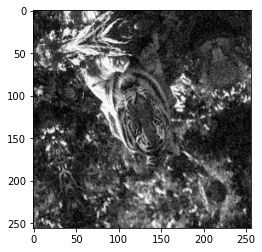

In [29]:
_ = np.random.choice(len(p))
plt.imshow(p[_],cmap="gray")

In [22]:
second = False
num_classes = 10
arch = 'splines'
order = 1
it_lim = 30
gamma = 1
degree = 3
loss = "L2"

In [23]:
model1 = get_model("splines",it_lim=3,image_size=image_size,num_classes = num_classes,second=second)

In [25]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss=getattr(losses,loss))

callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
tf.keras.callbacks.TerminateOnNaN()

]

history = model1.fit(
    gen_batch_train,
    epochs=20,
    steps_per_epoch=10,
    validation_data=gen_batch_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)


Epoch 1/20
10/10 [==============================] - 42s 4s/step - loss: 0.1692 - val_loss: 0.0085 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 35s 4s/step - loss: 0.1965 - val_loss: 0.0086 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 35s 4s/step - loss: 0.1125 - val_loss: 0.0075 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 34s 4s/step - loss: 0.0634 - val_loss: 0.0071 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 34s 4s/step - loss: 0.0270 - val_loss: 0.0084 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 35s 4s/step - loss: 0.0343 - val_loss: 0.0079 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 35s 4s/step - loss: 0.0253 - val_loss: 0.0081 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - 35s 4s/step - loss: 0.0074 - val_loss: 0.0074 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.0062
Epoch 9: ReduceLROnPlateau reducing l

KeyboardInterrupt: 

In [26]:
q = model1(xs)
#p = model(xs)

In [28]:
tf.image.psnr(ys,q,1)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([24.080545, 20.903028, 31.560585, 19.762285, 16.028322, 24.03828 ,
       16.360672, 19.628994, 32.59326 , 23.181551, 18.34023 , 29.631739,
       34.79111 , 21.32698 , 23.739958, 37.191925, 27.455297, 26.886347,
       19.931154, 16.330809, 21.097738, 24.839727, 28.717386, 18.90865 ,
       38.474766], dtype=float32)>

In [30]:
tf.image.psnr(ys,xs,1)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([23.861868, 20.608885, 31.537966, 19.380487, 15.575819, 23.784988,
       15.813452, 19.092306, 32.527122, 22.821033, 17.785057, 29.559708,
       34.66881 , 21.032469, 23.401243, 37.109108, 27.29334 , 26.738712,
       19.551682, 15.758532, 20.710697, 24.640118, 28.590944, 18.503218,
       38.452984], dtype=float32)>

# Data generation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=60,CROP1=CROP,BATCH_SIZE=25)

2023-04-09 13:01:44.724147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-09 13:01:44.724177: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 13:01:44.724201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-04-09 13:01:44.724531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [6]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

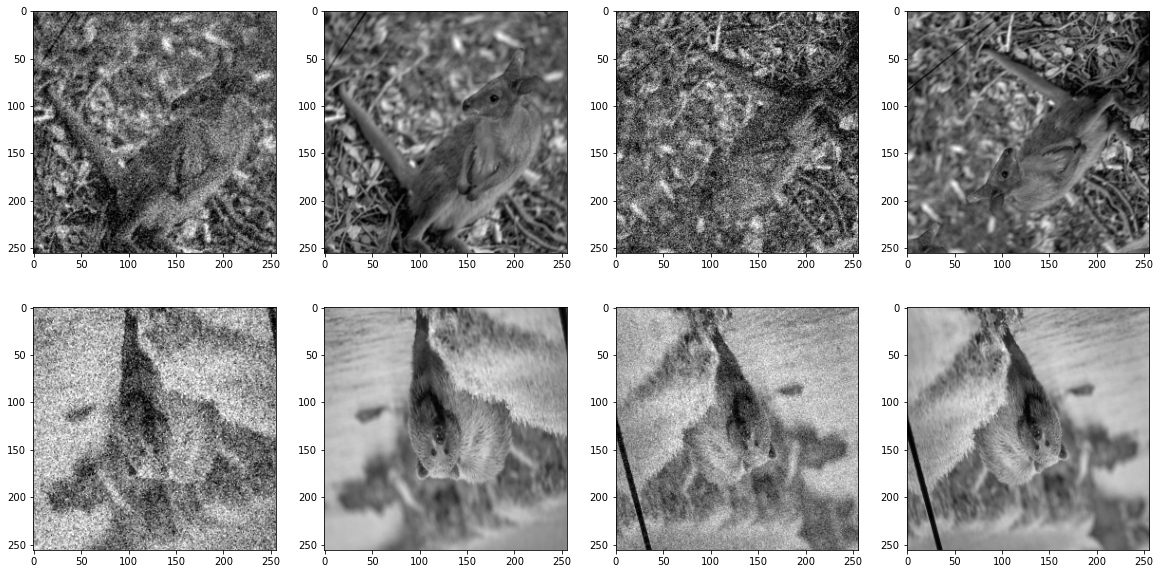

In [10]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()